In [142]:
import pandas as pd
import openpyxl
import numpy as np
from pathlib import Path
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import re
import os
import sys

In [143]:
import pmp_functions_v5 as pmp

Loading ...
Loading ...
Loading ...
Loading ...

--- RUNNING STRATEGY: EQUITY ---
   Assets: 7
   Avg Scaling Factor: 0.99x

--- RUNNING STRATEGY: BOND ---
   Assets: 7
   Avg Scaling Factor: 1.79x

--- RUNNING STRATEGY: RATES ---
   Assets: 7
   Avg Scaling Factor: 2.77x

--- RUNNING STRATEGY: FX ---
   Assets: 6
   Avg Scaling Factor: 1.58x

Final Portfolio Re-Scaling Factor: 1.81x

             PERFORMANCE SUMMARY PER ASSET CLASS       
                          Equity     Bond    Rates      FX  Total_Portfolio
Arithm Avg Total Return  -2.4283   2.0198   0.4850  2.0417           0.9608
Arithm Avg Xs Return     -4.4283   0.0198  -1.5150  0.0417          -1.0392
Std Xs Returns           12.1646  10.1934   1.8399  9.8384          10.0000
Sharpe Arithmetic        -0.3640   0.0019  -0.8234  0.0042          -0.1039
Geom Avg Total Return    -3.1516   1.5172   0.4692  1.5704           0.4637
Geom Avg Xs Return       -5.1700  -0.5013  -1.5493 -0.4480          -1.5547
Sharpe Geometric        

<Figure size 1200x800 with 0 Axes>

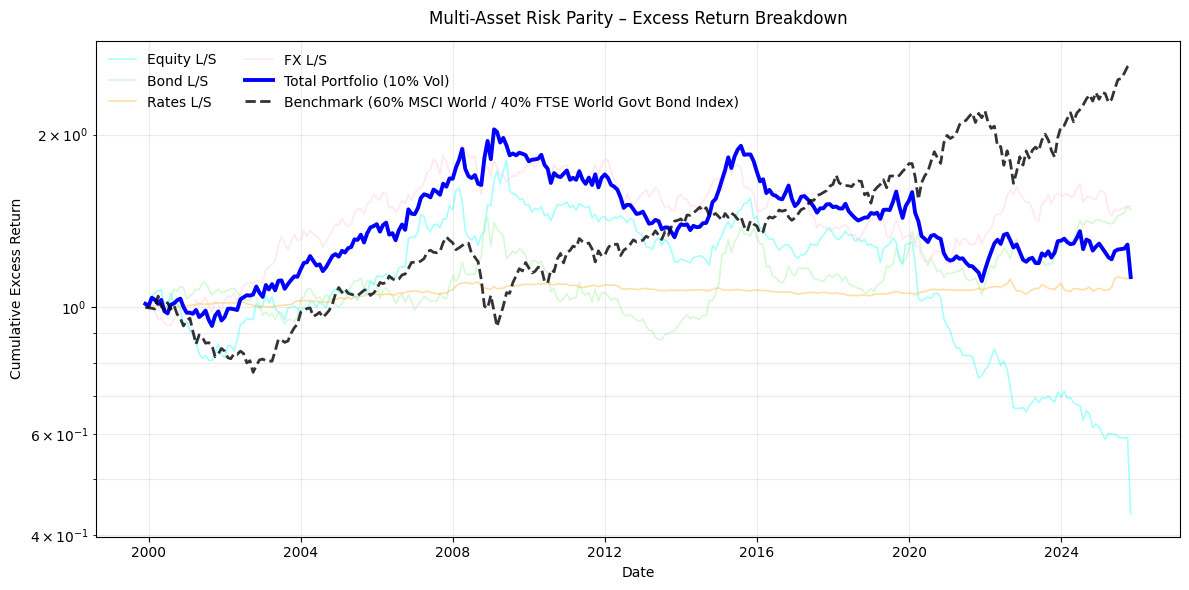

In [144]:
# =============================================================================
# --- CONFIGURATION & CONSTANTS ---
# =============================================================================

# Paths & Targets
VOL_TARGET = 0.1
VOL_WINDOW = 36
DATA_PATH = '../Data/'

# Strategy Parameters
MOMENTUM_LOOKBACKS = [1, 3, 12]  # Months for signal generation
SIGNAL_LAG = 1                   # Lag to apply to signal
K_SELECT = 3                     # Number of assets to select (CS Momentum)
MIN_ASSETS = 4                   # Min assets required to trade

# Risk Management & Costs
RF_ANNUAL = 0.02                 # Assumed risk-free rate (2%)
T_COST_BPS = 0.0000              # Transaction costs (10 basis points)
MAX_SCALAR_STRATEGY = 3.0        # Max leverage cap for individual asset class
MAX_SCALAR_PORTFOLIO = 3.0       # Max leverage cap for final aggregated portfolio

# Time & Frequency
ANNUALIZATION_FACTOR = 12
RESAMPLE_FREQ = "ME"             # Month End

# Derived Constants
RF_MONTHLY = RF_ANNUAL / ANNUALIZATION_FACTOR
T_COST = T_COST_BPS              # Passing directly as decimal if pmp expects decimal, or bps if expected bps

# =============================================================================
# 1. THE STRATEGY FACTORY
# =============================================================================
def run_independent_strategy(name, df_prices, benchmark, rf_series, k_select=K_SELECT, min_assets=MIN_ASSETS):
    """
    Runs a complete, isolated Momentum L/S strategy for a single asset class.
    """
    print(f"\n--- RUNNING STRATEGY: {name} ---")
    print(f"   Assets: {len(df_prices.columns)}")
    
    # A. Prepare Data
    returns = df_prices.pct_change().fillna(0)
    rf_series = rf_series.reindex(returns.index).fillna(RF_MONTHLY)
    
    # B. Signal Generation
    raw_signal = pd.DataFrame(0.0, index=df_prices.index, columns=df_prices.columns)
    
    for lag in MOMENTUM_LOOKBACKS:
        mom = df_prices.pct_change(lag)
        sig = np.sign(mom)
        raw_signal += sig
    
    final_signal = raw_signal / len(MOMENTUM_LOOKBACKS)
    
    # C. Weight Generation
    weights_unscaled = pmp.make_country_weights(
        signal=final_signal,
        returns=returns,
        benchmark_series=benchmark,
        k=k_select,            
        long_short=True,
        beta_neutral=False,    
        signal_lag=SIGNAL_LAG,
        min_regions=min_assets 
    )
    
    # D. Preliminary Backtest (Unscaled)
    # We use 0.0 cost here to get pure realized volatility for scaling
    res_unscaled = pmp.run_cc_strategy(
        weights=weights_unscaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=0.0, 
        benchmark=benchmark
    )
    
    # E. DYNAMIC Volatility Targeting (No Look-Ahead)
    ret_series = res_unscaled["ret_net"].fillna(0)
    
    # 1. Calculate Rolling Volatility
    rolling_vol = ret_series.rolling(window=VOL_WINDOW).std() * np.sqrt(ANNUALIZATION_FACTOR)
    
    # 2. Shift to avoid look-ahead (Vol at time T determines leverage at time T+1)
    rolling_vol = rolling_vol.shift(1)
    
    # 3. Calculate Dynamic Scalar
    # Replace 0 or NaN vols (start of series) with infinity to result in 0 leverage, 
    # OR set a default scalar of 1.0 for the warm-up period. Here we default to 1.0.
    scalar_series = VOL_TARGET / rolling_vol
    
    # 4. Cap leverage and fill missing data (warm-up period) with 1.0
    scalar_series = scalar_series.clip(upper=MAX_SCALAR_STRATEGY)
    scalar_series = scalar_series.replace([np.inf, -np.inf], 1.0).fillna(1.0)
    
    print(f"   Avg Scaling Factor: {scalar_series.mean():.2f}x")
    
    # F. Apply Dynamic Scaling to Weights
    # Align scalar_series to the weights dataframe
    weights_scaled = weights_unscaled.mul(scalar_series, axis=0)
    
    
    # F. Final Scaled Backtest
    res_final = pmp.run_cc_strategy(
        weights=weights_scaled,
        returns=returns,
        rf=rf_series,
        frequency=1,
        t_cost=T_COST, 
        benchmark=benchmark
    )
    
    return res_final

# =============================================================================
# 2. DATA LOADING & PREPROCESSING
# =============================================================================

def load_rf_csv(path: Path) -> pd.Series:
    """
    Load risk-free rate from CSV. 
    Format: Date, RF (returns)
    """
    df = pd.read_csv(path)
    
    # Parse dates and align to MonthEnd
    df["Date"] = pd.to_datetime(df["Date"]) + MonthEnd(0)
    
    df = df.set_index("Date").sort_index()
    
    # Return the RF column
    return df["RF"]

def load_and_process(filename, suffix, is_fx=False):
    """
    Helper to load and process data to avoid repetition.
    """
    print(f"Loading {suffix}...")
    full_path = os.path.join(DATA_PATH, filename)
    
    # Handle FX Returns vs Price data structure
    if is_fx:
        df = pd.read_excel(full_path, sheet_name="RETURNS", engine='openpyxl')
    else:
        df = pd.read_excel(full_path, engine='openpyxl')
        
    # Index setting
    if 'Date' in df.columns:
        df = df.set_index('Date')
    elif 'Dates' in df.columns:
        df = df.set_index('Dates')
    else:
        df = df.set_index(df.columns[0])
    
    df.index = pd.to_datetime(df.index, errors='coerce')
    
    # FX special handling
    if is_fx:
        df = (1 + df.fillna(0)).cumprod() * 100
    
    # Renaming and resampling
    df.columns = [f"{c}{suffix}" for c in df.columns]
    df = df.apply(pd.to_numeric, errors='coerce').resample(RESAMPLE_FREQ).last().ffill()
    
    # Ensure data goes up to 2025-11-30
    target_date = pd.Timestamp("2025-11-30")
    if df.index[-1] != target_date:
        last_row = df.iloc[[-1]].copy()
        last_row.index = [target_date]
        df = pd.concat([df, last_row]).sort_index()
    
    return df

# --- Load Assets ---
df_eq = load_and_process("Equity Data.xlsx", "")
df_bd = load_and_process("Bond Data.xlsx", "")
df_rt = load_and_process("Interest Rates Data.xlsx", "")
df_fx = load_and_process("FX Data.xlsx", "", is_fx=True)

rf_series = load_rf_csv(os.path.join(DATA_PATH, "RF.csv"))

# --- Load Benchmark ---
df_bench = pd.read_excel(os.path.join(DATA_PATH, "Benchmarks.xlsx"), engine='openpyxl')
if 'Date' in df_bench.columns: df_bench = df_bench.set_index('Date')
else: df_bench = df_bench.set_index(df_bench.columns[0])
df_bench.index = pd.to_datetime(df_bench.index, errors='coerce')
df_bench = df_bench.resample(RESAMPLE_FREQ).last().ffill()
benchmark_ret = df_bench['Full Benchmark'].pct_change().fillna(0)

# =============================================================================
# 3. EXECUTION PER ASSET CLASS
# =============================================================================

ret_equity = run_independent_strategy("EQUITY", df_eq, benchmark=benchmark_ret, rf_series=rf_series)
ret_bond = run_independent_strategy("BOND", df_bd, benchmark=benchmark_ret, rf_series=rf_series)
ret_rates = run_independent_strategy("RATES", df_rt, benchmark=benchmark_ret, rf_series=rf_series)
ret_fx = run_independent_strategy("FX", df_fx, benchmark=benchmark_ret, rf_series=rf_series)

# =============================================================================
# 4. AGGREGATION & PORTFOLIO CONSTRUCTION
# =============================================================================

# Combine Strategies
df_strategies = pd.DataFrame({
    'Equity': ret_equity["ret_net"],
    'Bond': ret_bond["ret_net"],
    'Rates': ret_rates["ret_net"],
    'FX': ret_fx["ret_net"]
}).dropna()

# Portfolio Construction (Equal Weight across strategies)
final_portfolio_ret = df_strategies.mean(axis=1)

# Re-Scale to Target Vol
port_vol = final_portfolio_ret.std() * np.sqrt(ANNUALIZATION_FACTOR)
final_scalar = VOL_TARGET / port_vol if port_vol > 0 else 1.0
final_scalar = min(final_scalar, MAX_SCALAR_PORTFOLIO)
final_portfolio_ret = final_portfolio_ret * final_scalar

print(f"\nFinal Portfolio Re-Scaling Factor: {final_scalar:.2f}x")

# Create Consolidated Dataframe for Summary
df_all = df_strategies.copy()
df_all['Total_Portfolio'] = final_portfolio_ret

# Align everything
common_idx = df_all.index.intersection(benchmark_ret.index)
df_all = df_all.loc[common_idx]
bm_aligned = benchmark_ret.loc[common_idx]
rf_aligned = pd.Series(RF_MONTHLY, index=common_idx)

# Calculate Excess Returns
xs_all = df_all.sub(rf_aligned, axis=0)
xs_bench = (bm_aligned - rf_aligned).to_frame()

# =============================================================================
# 5. SUMMARY
# =============================================================================

print("\n=======================================================")
print("             PERFORMANCE SUMMARY PER ASSET CLASS       ")
print("=======================================================")

summary = pmp.summarizePerformance(
    xsReturns=xs_all.values,
    Rf=rf_aligned.values.reshape(-1, 1),
    factorXsReturns=xs_bench.values, 
    annualizationFactor=ANNUALIZATION_FACTOR,
    strategyNames=df_all.columns.tolist()
)

print(summary)

# Correlation Matrix
print("\n--- Correlation Matrix ---")
print(df_all.corr().round(2))

# =============================================================================
# 6. VISUALIZATION
# =============================================================================
cum_all = (1 + df_all).cumprod()
cum_bench = (1 + xs_bench).cumprod()

plt.figure(figsize=(12, 8))
colors = ['cyan', 'lightgreen', 'orange', 'pink']

# Plot Components
fig, ax = plt.subplots(figsize=(12, 6))

# Component strategies (light, semi-transparent)
for i, col in enumerate(df_strategies.columns):
    ax.plot(
        cum_all[col],
        label=f"{col} L/S",
        linewidth=1.2,
        alpha=0.35,
        color=colors[i],
    )

# Total Portfolio (strong highlight)
ax.plot(
    cum_all['Total_Portfolio'],
    label=f"Total Portfolio ({VOL_TARGET:.0%} Vol)",
    linewidth=2.8,
    color="blue",
)

# Benchmark (clean dashed)
ax.plot(
    cum_bench,
    label="Benchmark (60% MSCI World / 40% FTSE World Govt Bond Index)",
    linewidth=2,
    linestyle="--",
    color="black",
    alpha=0.8,
)

# Zero line for excess returns (important)
ax.axhline(0, color="gray", linewidth=1, alpha=0.4)

# Labels & title
ax.set_title("Multi-Asset Risk Parity – Excess Return Breakdown", pad=12)
ax.set_ylabel("Cumulative Excess Return")
ax.set_xlabel("Date")
ax.set_yscale("log")

# Legend
ax.legend(frameon=False, ncol=2)

# Grid
ax.grid(True, which="both", alpha=0.25)

plt.tight_layout()
plt.show()

## Equity Table

In [149]:
ret_equity.to_csv("../Results/trend_equity.csv")
ret_equity.loc["2005-12-31":"2007-11-30"]

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_US,w_AU,w_CH,w_JP,w_UK,w_EM,w_EU
Date,,,,,,,,,,,,,
2005-12-31,0.037214,0.037214,0.017077,1.108310,0.0,0.004208,-0.383455,-0.383455,0.511273,0.511273,0.063909,0.063909,-0.383455
2006-01-31,-0.000098,-0.000098,0.029591,0.836532,0.0,0.004008,-0.385017,-0.385017,0.693030,0.154007,-0.385017,0.154007,0.154007
2006-02-28,-0.003841,-0.003841,-0.002953,0.511628,0.0,0.003807,-0.379097,-0.379097,0.379097,0.379097,-0.379097,0.000000,0.379097
2006-03-31,0.013637,0.013637,0.006510,0.966730,0.0,0.004610,-0.396335,-0.396335,-0.396335,0.297251,0.297251,0.297251,0.297251
2006-04-30,-0.025183,-0.025183,0.027651,0.019090,0.0,0.003807,-0.409405,-0.409405,-0.409405,0.307054,0.307054,0.307054,0.307054
2006-05-31,0.013688,0.013688,-0.009579,0.039160,0.0,0.004409,-0.415668,-0.415668,-0.415668,0.311751,0.311751,0.311751,0.311751
2006-06-30,-0.002295,-0.002295,-0.004859,0.155566,0.0,0.004409,-0.452661,-0.452661,-0.452661,0.339496,0.339496,0.339496,0.339496
2006-07-31,0.037560,0.037560,0.007211,1.329915,0.0,0.004008,-0.457146,-0.457146,0.609529,-0.457146,0.609529,0.076191,0.076191
2006-08-31,0.005899,0.005899,0.018441,1.321352,0.0,0.004610,-0.458828,0.458828,-0.458828,-0.458828,0.458828,0.000000,0.458828


## Bond Table

In [146]:
ret_bond.to_csv("../Results/trend_bond.csv")
ret_bond

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_EU,w_JP,w_AU,w_US,w_CH,w_EM,w_UK
Date,,,,,,,,,,,,,
1999-03-31,0.000000,0.000000,0.000000,0.000000,0.0,0.004610,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-04-30,0.016882,0.016882,0.000000,1.000000,0.0,0.004208,-0.333333,0.444444,-0.333333,-0.333333,0.444444,0.055556,0.055556
1999-05-31,0.014714,0.014714,0.000000,0.311197,0.0,0.004008,-0.333333,0.600000,-0.333333,-0.333333,0.133333,0.133333,0.133333
1999-06-30,0.005773,0.005773,0.000000,0.868664,0.0,0.004409,-0.333333,0.333333,-0.333333,0.333333,0.333333,0.000000,-0.333333
1999-07-31,0.002298,0.002298,0.000000,0.677976,0.0,0.004208,-0.333333,0.444444,-0.333333,-0.333333,0.444444,0.055556,0.055556
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.023689,0.023689,0.038273,1.973997,0.0,0.004008,0.765845,-0.765845,-0.765845,0.765845,0.765845,-0.765845,0.000000
2025-07-31,0.003707,0.003707,0.006737,3.082539,0.0,0.004409,-0.765303,-0.765303,0.127550,-0.765303,1.020403,1.020403,0.127550
2025-08-31,0.005979,0.005979,0.023840,1.831510,0.0,0.001667,-0.775759,-0.775759,-0.775759,1.034345,1.034345,0.129293,0.129293


## Rate Table

In [147]:
ret_rates.to_csv("../Results/trend_rates.csv")
ret_rates

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_CH,w_EU,w_AU,w_US,w_EM,w_UK,w_JP
Date,,,,,,,,,,,,,
1999-04-30,0.000000,0.000000,0.000000,0.000000,0.0,0.004208,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1999-05-31,-0.000287,-0.000287,0.000000,1.000000,0.0,0.004008,-0.5,0.083333,0.666667,-0.5,0.083333,0.083333,0.083333
1999-06-30,-0.003384,-0.003384,0.000000,1.416471,0.0,0.004409,0.5,0.000000,-0.500000,-0.5,0.500000,0.000000,0.000000
1999-07-31,-0.002785,-0.002785,0.000000,1.001188,0.0,0.004208,-0.5,0.000000,0.000000,-0.5,0.500000,0.000000,0.500000
1999-08-31,0.000009,0.000009,0.000000,0.833271,0.0,0.004409,-0.5,0.083333,0.666667,-0.5,0.083333,0.083333,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.006585,0.006585,0.038273,6.010986,0.0,0.004008,-1.0,1.000000,1.000000,-1.0,0.000000,1.000000,-1.000000
2025-07-31,-0.003300,-0.003300,0.006737,1.003394,0.0,0.004409,-1.0,1.000000,1.000000,-1.0,1.000000,0.000000,-1.000000
2025-08-31,-0.003431,-0.003431,0.023840,1.001650,0.0,0.001667,-1.0,1.000000,1.000000,-1.0,0.000000,1.000000,-1.000000


## FX Table

In [148]:
ret_fx.to_csv("../Results/trend_fx.csv")
ret_fx

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_CH,w_EU,w_JP,w_UK,w_AU,w_EM
Date,,,,,,,,,,,,
1990-03-31,0.000000,0.000000,0.000000,0.000000,0.0,0.006621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1990-04-30,0.017985,0.017985,0.000000,1.000000,0.0,0.006017,0.466667,-0.333333,-0.333333,0.466667,-0.333333,0.066667
1990-05-31,-0.003832,-0.003832,0.000000,0.009835,0.0,0.006621,0.466667,-0.333333,-0.333333,0.466667,-0.333333,0.066667
1990-06-30,0.033762,0.033762,0.000000,0.687751,0.0,0.006319,0.333333,-0.333333,-0.333333,0.333333,0.333333,-0.333333
1990-07-31,0.030135,0.030135,0.000000,0.017289,0.0,0.006319,0.333333,-0.333333,-0.333333,0.333333,0.333333,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,-0.007049,-0.007049,0.038273,3.651139,0.0,0.004008,-0.756137,1.058592,1.058592,0.151227,-0.756137,-0.756137
2025-07-31,0.008686,0.008686,0.006737,3.652014,0.0,0.004409,1.047175,-0.747982,-0.747982,1.047175,-0.747982,0.149596
2025-08-31,0.004513,0.004513,0.023840,1.483657,0.0,0.001667,0.756514,0.756514,-0.756514,0.756514,-0.756514,-0.756514
